In [3]:
import pandas as pd

# Upload cleaned_file.csv from your laptop
#uploaded = files.upload()

# Replace the name if your file is different
df = pd.read_csv('cleaned_file.csv', low_memory=False)
df.head()


,ResNumber,EntityCode,ServiceAreaCode,DispatchVehicleCode,DispatchDriverCode,Pickup Date,Pickup DateTime,Passenger,CustomerCode,InvoiceNumber,...,OnLocationDateTime,PassengerEmailAddress,CustomerName,NumberOfPassengers,CCBatchRowId$1476,CreditCardNumberPartial,Distance,Pickup Country,Dropoff Country,PassengerOnBoardDateTime
0,1090385*1,SUN-NW,US-NYC,1619,251619,2024-10-01 00:00:00,2024-10-01 00:00:00,"CREW,AVIANCA",61789,292114.0,...,2024-10-01 00:02:00,NaN,Avianca (Long Island Marriott),7,NaN,NaN,17.80,US,US,2024-10-01 00:02:00
1,1087026*7,SUN-NW,US-NYC,1696-1,251696-1,2024-10-01 00:00:00,2024-10-01 00:20:00,"CREW,AVIANCA",61789,292114.0,...,2024-09-30 23:30:00,NaN,Avianca (Long Island Marriott),9,NaN,NaN,17.80,US,US,2024-10-01 00:23:00
2,1085036*1,SUN-LA,US-WDC,8498,108498,2024-10-01 00:00:00,2024-10-01 00:26:00,"RODRIGUEZ,JOSE",50241,NaN,...,2024-10-01 00:06:00,NaN,AMGEN VVIP,1,11303.0,1007,31.13,US,US,2024-10-01 01:06:00
3,1090466*1,SUN-NW,US-NYC,2890,251223-00,2024-10-01 00:00:00,2024-10-01 00:40:00,"CREW,AVIANCA",61789,292114.0,...,2024-09-30 23:49:00,NaN,Avianca (Long Island Marriott),7,NaN,NaN,19.93,US,US,2024-10-01 00:53:00
4,1089861*1,SUN-NW,US-WDC,1246,109244,2024-10-01 00:00:00,2024-10-01 00:53:00,"POLAK,BENJAMIN",6405,291427.0,...,2024-09-30 23:47:00,POLAK.BEN@BCG.COM;GARITY.KATHY@BCG.COM;GENINVO...,BOSTON CONSULTING DALLAS,1,NaN,NaN,4.01,US,US,2024-10-01 00:59:00


In [4]:
time_cols = [
    'Pickup DateTime',
    'OnLocationDateTime',
    'PassengerOnBoardDateTime',
    'SegmentEndDateTime'
]

for col in time_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

df[time_cols].head()


,Pickup DateTime,OnLocationDateTime,PassengerOnBoardDateTime,SegmentEndDateTime
0,2024-10-01 00:00:00,2024-10-01 00:02:00,2024-10-01 00:02:00,2024-10-01 00:29:00
1,2024-10-01 00:20:00,2024-09-30 23:30:00,2024-10-01 00:23:00,2024-10-01 00:46:00
2,2024-10-01 00:26:00,2024-10-01 00:06:00,2024-10-01 01:06:00,2024-10-01 01:43:00
3,2024-10-01 00:40:00,2024-09-30 23:49:00,2024-10-01 00:53:00,2024-10-01 01:19:00
4,2024-10-01 00:53:00,2024-09-30 23:47:00,2024-10-01 00:59:00,2024-10-01 01:08:00


In [5]:
import numpy as np

# Choose actual pickup time
df['ActualPickup'] = df['PassengerOnBoardDateTime'].combine_first(df['OnLocationDateTime'])

# Calculate delay in minutes
df['PickupDelay_min'] = (
    (df['ActualPickup'] - df['Pickup DateTime'])
    .dt.total_seconds() / 60
)

# Flag rule
def classify_delay(x):
    if pd.isna(x):
        return 'UNKNOWN'
    elif x > 15:
        return 'DELAY BREACH'
    elif x < -15:
        return 'VERY EARLY'
    else:
        return 'ON-TIME'

df['PickupDelay_Flag'] = df['PickupDelay_min'].apply(classify_delay)

df[['ResNumber', 'Pickup DateTime', 'ActualPickup', 'PickupDelay_min', 'PickupDelay_Flag']].head()


,ResNumber,Pickup DateTime,ActualPickup,PickupDelay_min,PickupDelay_Flag
0,1090385*1,2024-10-01 00:00:00,2024-10-01 00:02:00,2.0,ON-TIME
1,1087026*7,2024-10-01 00:20:00,2024-10-01 00:23:00,3.0,ON-TIME
2,1085036*1,2024-10-01 00:26:00,2024-10-01 01:06:00,40.0,DELAY BREACH
3,1090466*1,2024-10-01 00:40:00,2024-10-01 00:53:00,13.0,ON-TIME
4,1089861*1,2024-10-01 00:53:00,2024-10-01 00:59:00,6.0,ON-TIME


In [6]:
# Make sure these columns exist
print('Total' in df.columns, 'Distance' in df.columns, 'PriceBook' in df.columns)


True True True


In [7]:
# Avoid division by zero
valid_fares = df[(df['Distance'] > 0) & (df['Total'] > 0)]

rate_table = (
    valid_fares
    .groupby('PriceBook')
    .apply(lambda g: g['Total'].sum() / g['Distance'].sum())
    .rename('RatePerMile')
    .reset_index()
)

rate_table.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_5456\456309921.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['Total'].sum() / g['Distance'].sum())


,PriceBook,RatePerMile
0,003,13.985450
1,029,6.981396
2,036,16.442286
3,2019AF,11.225983
4,2019DCRT,13.200317


In [8]:
# Join rate back to main df
df = df.merge(rate_table, on='PriceBook', how='left')

# Expected fare
df['ExpectedFare'] = df['RatePerMile'] * df['Distance']

# % error between billed and expected
df['FareError_pct'] = (df['Total'] - df['ExpectedFare']) / df['ExpectedFare'] * 100

def classify_pricing(err):
    if pd.isna(err):
        return 'UNKNOWN'
    elif abs(err) > 10:      # >10% deviation → breach
        return 'PRICING BREACH'
    else:
        return 'OK'

df['Pricing_Flag'] = df['FareError_pct'].apply(classify_pricing)

df[['ResNumber', 'PriceBook', 'Distance', 'Total', 'ExpectedFare', 'FareError_pct', 'Pricing_Flag']].head()


,ResNumber,PriceBook,Distance,Total,ExpectedFare,FareError_pct,Pricing_Flag
0,1090385*1,2019NY,17.80,110.00,157.895740,-30.333776,PRICING BREACH
1,1087026*7,2019NY,17.80,110.00,157.895740,-30.333776,PRICING BREACH
2,1085036*1,003,31.13,165.33,435.367049,-62.025146,PRICING BREACH
3,1090466*1,2019NY,19.93,110.00,176.790005,-37.779288,PRICING BREACH
4,1089861*1,2023BCG,4.01,91.15,26.621181,242.396534,PRICING BREACH


In [9]:
def classify_ack(row):
    driver = row['DispatchDriverCode']
    end    = row['SegmentEndDateTime']

    if pd.isna(driver):
        return 'UNASSIGNED DRIVER'
    elif pd.isna(end):
        return 'OPEN SEGMENT'
    else:
        return 'ACKNOWLEDGED & CLOSED'

df['ServiceAck_Flag'] = df.apply(classify_ack, axis=1)

df[['ResNumber', 'DispatchDriverCode', 'SegmentEndDateTime', 'ServiceAck_Flag']].head()


,ResNumber,DispatchDriverCode,SegmentEndDateTime,ServiceAck_Flag
0,1090385*1,251619,2024-10-01 00:29:00,ACKNOWLEDGED & CLOSED
1,1087026*7,251696-1,2024-10-01 00:46:00,ACKNOWLEDGED & CLOSED
2,1085036*1,108498,2024-10-01 01:43:00,ACKNOWLEDGED & CLOSED
3,1090466*1,251223-00,2024-10-01 01:19:00,ACKNOWLEDGED & CLOSED
4,1089861*1,109244,2024-10-01 01:08:00,ACKNOWLEDGED & CLOSED


In [10]:
def overall_alert(row):
    if row['PickupDelay_Flag'] == 'DELAY BREACH':
        return 'RED – DELAY'
    if row['Pricing_Flag'] == 'PRICING BREACH':
        return 'RED – PRICING'
    if row['ServiceAck_Flag'] in ['UNASSIGNED DRIVER', 'OPEN SEGMENT']:
        return 'RED – SERVICE'
    return 'GREEN – OK'

df['AlertLevel'] = df.apply(overall_alert, axis=1)

df[['ResNumber', 'PickupDelay_Flag', 'Pricing_Flag', 'ServiceAck_Flag', 'AlertLevel']].head()


,ResNumber,PickupDelay_Flag,Pricing_Flag,ServiceAck_Flag,AlertLevel
0,1090385*1,ON-TIME,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
1,1087026*7,ON-TIME,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
2,1085036*1,DELAY BREACH,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – DELAY
3,1090466*1,ON-TIME,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
4,1089861*1,ON-TIME,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING


In [11]:
def color_alert(val):
    if isinstance(val, str) and val.startswith('RED'):
        return 'background-color: #ffcccc; color: red; font-weight: bold'
    elif isinstance(val, str) and val.startswith('GREEN'):
        return 'background-color: #ccffcc; color: green; font-weight: bold'
    return ''

df_display = df[['ResNumber', 'PickupDelay_Flag', 'Pricing_Flag',
                 'ServiceAck_Flag', 'AlertLevel']].head(20)

df_display.style.applymap(color_alert, subset=['AlertLevel'])


C:\Users\Admin\AppData\Local\Temp\ipykernel_5456\2383896765.py:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_display.style.applymap(color_alert, subset=['AlertLevel'])


,ResNumber,PickupDelay_Flag,Pricing_Flag,ServiceAck_Flag,AlertLevel
0,1090385*1,ON-TIME,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
1,1087026*7,ON-TIME,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
2,1085036*1,DELAY BREACH,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – DELAY
3,1090466*1,ON-TIME,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
4,1089861*1,ON-TIME,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
5,1090555*1,ON-TIME,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
6,1090552*1,DELAY BREACH,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – DELAY
7,1076604*1,ON-TIME,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
8,972229*183,ON-TIME,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
9,1090430*1,DELAY BREACH,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – DELAY


In [14]:
df.head()

,ResNumber,EntityCode,ServiceAreaCode,DispatchVehicleCode,DispatchDriverCode,Pickup Date,Pickup DateTime,Passenger,CustomerCode,InvoiceNumber,...,PassengerOnBoardDateTime,ActualPickup,PickupDelay_min,PickupDelay_Flag,RatePerMile,ExpectedFare,FareError_pct,Pricing_Flag,ServiceAck_Flag,AlertLevel
0,1090385*1,SUN-NW,US-NYC,1619,251619,2024-10-01 00:00:00,2024-10-01 00:00:00,"CREW,AVIANCA",61789,292114.0,...,2024-10-01 00:02:00,2024-10-01 00:02:00,2.0,ON-TIME,8.870547,157.895740,-30.333776,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
1,1087026*7,SUN-NW,US-NYC,1696-1,251696-1,2024-10-01 00:00:00,2024-10-01 00:20:00,"CREW,AVIANCA",61789,292114.0,...,2024-10-01 00:23:00,2024-10-01 00:23:00,3.0,ON-TIME,8.870547,157.895740,-30.333776,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
2,1085036*1,SUN-LA,US-WDC,8498,108498,2024-10-01 00:00:00,2024-10-01 00:26:00,"RODRIGUEZ,JOSE",50241,NaN,...,2024-10-01 01:06:00,2024-10-01 01:06:00,40.0,DELAY BREACH,13.985450,435.367049,-62.025146,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – DELAY
3,1090466*1,SUN-NW,US-NYC,2890,251223-00,2024-10-01 00:00:00,2024-10-01 00:40:00,"CREW,AVIANCA",61789,292114.0,...,2024-10-01 00:53:00,2024-10-01 00:53:00,13.0,ON-TIME,8.870547,176.790005,-37.779288,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING
4,1089861*1,SUN-NW,US-WDC,1246,109244,2024-10-01 00:00:00,2024-10-01 00:53:00,"POLAK,BENJAMIN",6405,291427.0,...,2024-10-01 00:59:00,2024-10-01 00:59:00,6.0,ON-TIME,6.638698,26.621181,242.396534,PRICING BREACH,ACKNOWLEDGED & CLOSED,RED – PRICING


In [13]:
df.to_csv('KPI_data.csv')

In [11]:
import pandas as pd

total_trips = len(df)

delay_breaches = (df['PickupDelay_Flag'] == 'DELAY BREACH').sum()
pricing_breaches = (df['Pricing_Flag'] == 'PRICING BREACH').sum()
service_issues = df['ServiceAck_Flag'].isin(['UNASSIGNED DRIVER', 'OPEN SEGMENT']).sum()
any_breach = df['AlertLevel'].str.startswith('RED').sum()

summary_kpi = pd.DataFrame({
    'Metric': [
        'Total Trips',
        'Pickup Delay Breaches',
        'Pricing Breaches',
        'Unacknowledged / Open Service Requests',
        'Trips with ANY Breach'
    ],
    'Count': [
        total_trips,
        delay_breaches,
        pricing_breaches,
        service_issues,
        any_breach
    ]
})

summary_kpi['% of Trips'] = (summary_kpi['Count'] / total_trips * 100).round(2)

summary_kpi


,Metric,Count,% of Trips
0,Total Trips,93761,100.00
1,Pickup Delay Breaches,47123,50.26
2,Pricing Breaches,83058,88.58
3,Unacknowledged / Open Service Requests,9306,9.93
4,Trips with ANY Breach,89161,95.09


In [12]:
# trips where something went wrong
df_breach = df[df['AlertLevel'].str.startswith('RED')]

driver_summary = (
    df_breach
    .groupby('DispatchDriverCode')
    .size()
    .reset_index(name='BreachCount')
    .sort_values('BreachCount', ascending=False)
    .head(10)
)

driver_summary


,DispatchDriverCode,BreachCount
2182,251696-1,2304
2181,251696,2263
1396,251619,1953
1344,251223-00,1329
2260,251714,1326
384,109246,1112
1404,251654,1012
1378,251547-13,963
10,100495,933
2266,251732,931


In [13]:
area_summary = (
    df_breach
    .groupby('ServiceAreaCode')
    .size()
    .reset_index(name='BreachCount')
    .sort_values('BreachCount', ascending=False)
)

area_summary.head(10)


,ServiceAreaCode,BreachCount
0,US-NYC,56110
1,US-WDC,33051


In [14]:
pickup_rule_table = (
    df['PickupDelay_Flag']
    .value_counts()
    .reset_index(name='Count') # Explicitly name the counts column 'Count'
)
pickup_rule_table.rename(columns={'index': 'PickupDelay_Flag'}, inplace=True)

pickup_rule_table['% of Trips'] = (pickup_rule_table['Count'] / total_trips * 100).round(2)
pickup_rule_table

,PickupDelay_Flag,Count,% of Trips
0,DELAY BREACH,47123,50.26
1,ON-TIME,43648,46.55
2,VERY EARLY,1626,1.73
3,UNKNOWN,1364,1.45


In [15]:
pricing_rule_table = (
    df['Pricing_Flag']
    .value_counts()
    .reset_index(name='Count') # Explicitly name the counts column 'Count'
)
pricing_rule_table.rename(columns={'index': 'Pricing_Flag'}, inplace=True)

pricing_rule_table['% of Trips'] = (pricing_rule_table['Count'] / total_trips * 100).round(2)
pricing_rule_table

,Pricing_Flag,Count,% of Trips
0,PRICING BREACH,83058,88.58
1,OK,10145,10.82
2,UNKNOWN,558,0.60


In [16]:
service_rule_table = (
    df['ServiceAck_Flag']
    .value_counts()
    .reset_index(name='Count') # Explicitly name the counts column 'Count'
)
service_rule_table.rename(columns={'index': 'ServiceAck_Flag'}, inplace=True)

service_rule_table['% of Trips'] = (service_rule_table['Count'] / total_trips * 100).round(2)
service_rule_table

,ServiceAck_Flag,Count,% of Trips
0,ACKNOWLEDGED & CLOSED,84455,90.07
1,OPEN SEGMENT,8429,8.99
2,UNASSIGNED DRIVER,877,0.94


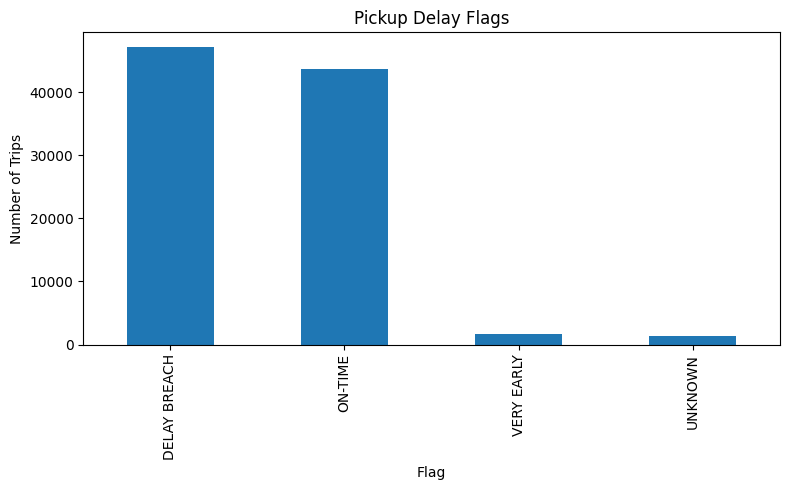

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
df['PickupDelay_Flag'].value_counts().plot(kind='bar')
plt.title("Pickup Delay Flags")
plt.xlabel("Flag")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()


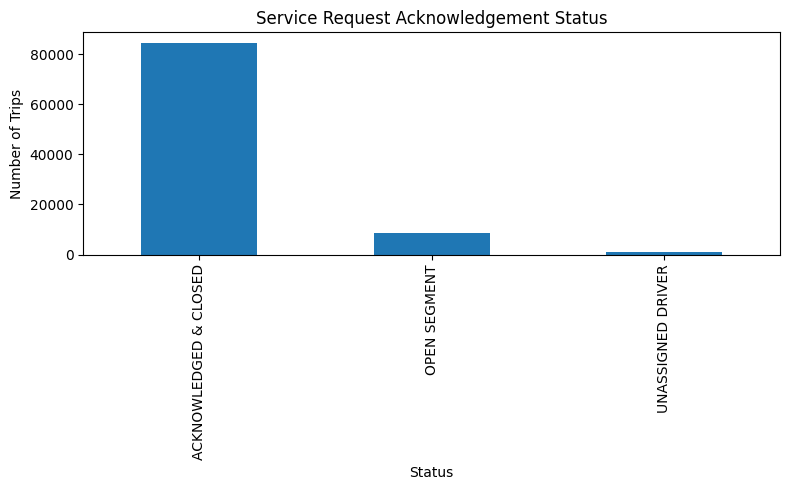

In [18]:
plt.figure(figsize=(8,5))
df['ServiceAck_Flag'].value_counts().plot(kind='bar')
plt.title("Service Request Acknowledgement Status")
plt.xlabel("Status")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()


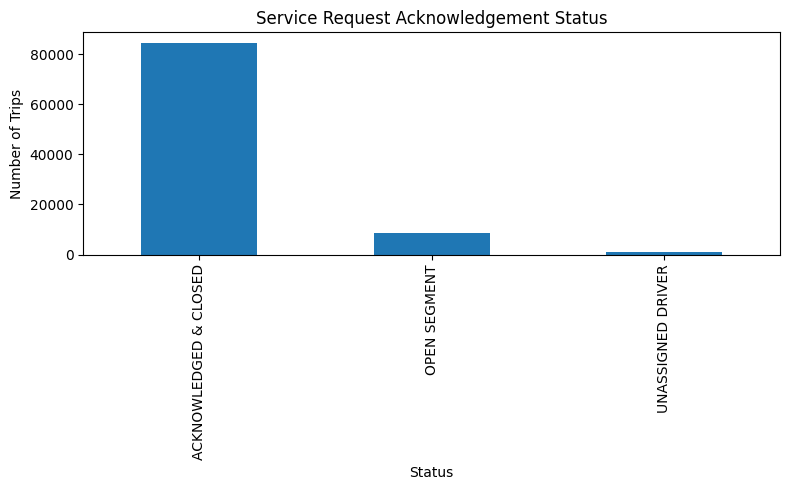

In [19]:
plt.figure(figsize=(8,5))
df['ServiceAck_Flag'].value_counts().plot(kind='bar')
plt.title("Service Request Acknowledgement Status")
plt.xlabel("Status")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()


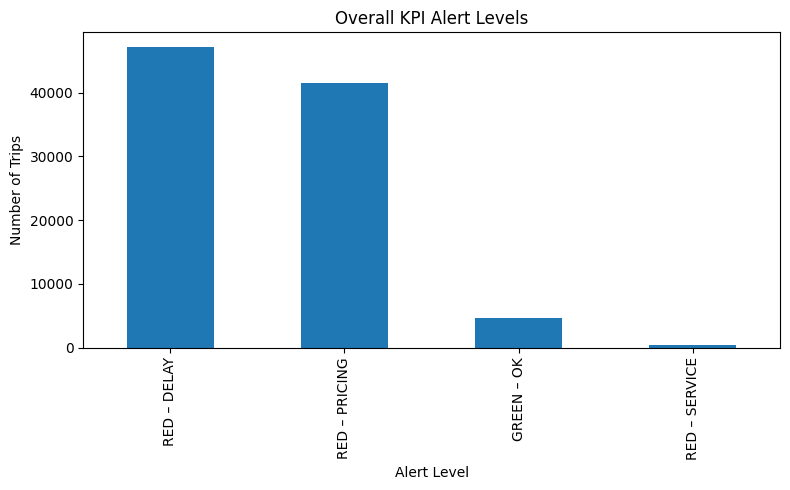

In [20]:
plt.figure(figsize=(8,5))
df['AlertLevel'].value_counts().plot(kind='bar')
plt.title("Overall KPI Alert Levels")
plt.xlabel("Alert Level")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()


In [21]:
plt.savefig("overall_alerts.png", dpi=300)


<Figure size 640x480 with 0 Axes>

In [22]:
driver_kpi = (
    df
    .assign(Breach = df['AlertLevel'].str.startswith('RED'))
    .groupby('DispatchDriverCode')
    .agg(
        TotalTrips = ('ResNumber', 'count'),
        BreachTrips = ('Breach', 'sum')
    )
)

driver_kpi['BreachRate_%'] = (driver_kpi['BreachTrips'] / driver_kpi['TotalTrips'] * 100).round(2)
driver_kpi.sort_values('BreachRate_%', ascending=False).head(10)


,TotalTrips,BreachTrips,BreachRate_%
DispatchDriverCode,,,
F20223-01,1,1,100.0
252000-3799,1,1,100.0
252000-0425,1,1,100.0
252000-0124,1,1,100.0
251975,7,7,100.0
251974-9996,2,2,100.0
251974-9923,1,1,100.0
251974-9756,1,1,100.0
251974-9753,2,2,100.0


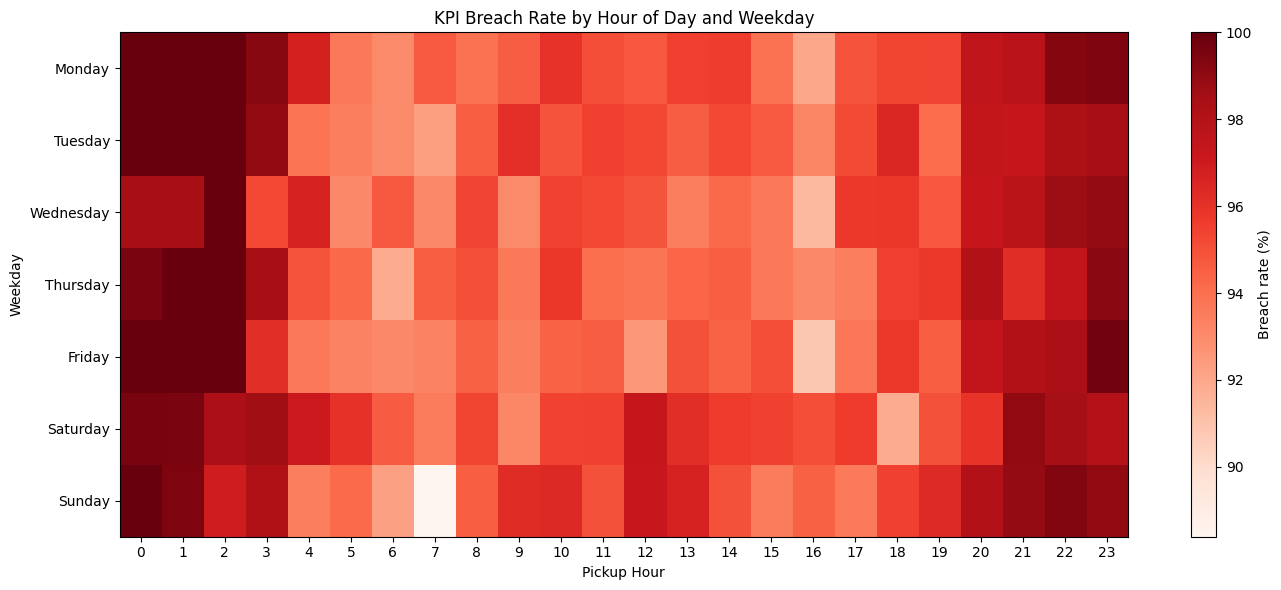

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Extra time features
df['PickupHour'] = df['Pickup DateTime'].dt.hour
df['PickupWeekday'] = df['Pickup DateTime'].dt.day_name()

# 2. Breach indicator (1 = some RED alert, 0 = OK)
df['IsBreach'] = df['AlertLevel'].str.startswith('RED').astype(int)

# 3. Pivot: mean(IsBreach) = breach rate
heat_data = (
    df.pivot_table(
        values='IsBreach',
        index='PickupWeekday',
        columns='PickupHour',
        aggfunc='mean'
    ) * 100
).reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

# 4. Plot heatmap
plt.figure(figsize=(14,6))
im = plt.imshow(heat_data, aspect='auto', cmap='Reds')

plt.colorbar(im, label='Breach rate (%)')
plt.xticks(ticks=np.arange(0,24), labels=heat_data.columns)
plt.yticks(ticks=np.arange(0,7), labels=heat_data.index)

plt.title("KPI Breach Rate by Hour of Day and Weekday")
plt.xlabel("Pickup Hour")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()


In [24]:
# Aggregate KPI per driver
driver_kpi = (
    df.assign(Breach=df['AlertLevel'].str.startswith('RED'))
      .groupby('DispatchDriverCode')
      .agg(
          TotalTrips=('ResNumber', 'count'),
          BreachTrips=('Breach', 'sum')
      )
)

driver_kpi['BreachRate_%'] = (driver_kpi['BreachTrips'] / driver_kpi['TotalTrips'] * 100)

# Keep only drivers with enough trips (e.g., >= 20)
driver_kpi_filtered = (
    driver_kpi[driver_kpi['TotalTrips'] >= 20]
    .sort_values('BreachRate_%', ascending=False)
    .head(15)
    .round(2)
)

driver_kpi_styled = driver_kpi_filtered.style.background_gradient(
    subset=['BreachRate_%'],
    cmap='Reds'
).format({'BreachRate_%': '{:.2f}'})

driver_kpi_styled


,TotalTrips,BreachTrips,BreachRate_%
DispatchDriverCode,,,
Disp11,34,34,100.00
DISP04,84,84,100.00
251723,21,21,100.00
1082601,59,59,100.00
108260,30,30,100.00
108144,78,78,100.00
1080281,33,33,100.00
100520,34,34,100.00
251696-8,64,64,100.00


<Figure size 1000x600 with 0 Axes>

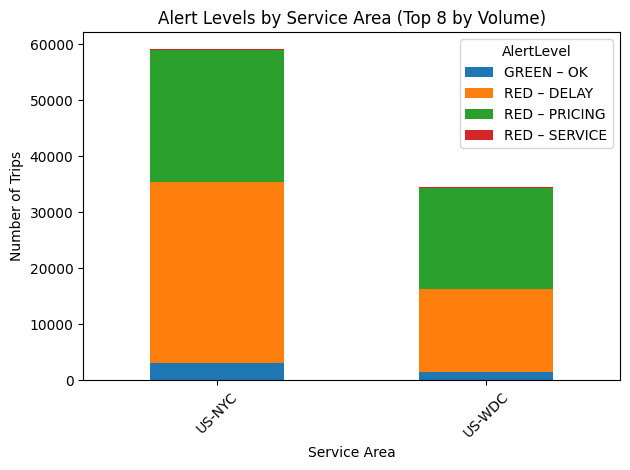

In [25]:
# Pivot: counts of each alert level per service area
area_alerts = (
    df.pivot_table(
        index='ServiceAreaCode',
        columns='AlertLevel',
        values='ResNumber',
        aggfunc='count'
    )
    .fillna(0)
)

# Only top 8 areas by total volume
area_alerts['Total'] = area_alerts.sum(axis=1)
area_alerts_top = area_alerts.sort_values('Total', ascending=False).head(8)
area_alerts_top = area_alerts_top.drop(columns=['Total'])

# Plot stacked bar
plt.figure(figsize=(10,6))
area_alerts_top.plot(kind='bar', stacked=True)
plt.title("Alert Levels by Service Area (Top 8 by Volume)")
plt.xlabel("Service Area")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
total_trips = len(df)

summary_kpi = pd.DataFrame({
    'Metric': [
        'Total Trips',
        'Trips with Pickup Delay Breach',
        'Trips with Pricing Breach',
        'Trips with Service Acknowledgement Issue',
        'Trips with ANY Red Alert'
    ],
    'Count': [
        total_trips,
        (df['PickupDelay_Flag']=='DELAY BREACH').sum(),
        (df['Pricing_Flag']=='PRICING BREACH').sum(),
        df['ServiceAck_Flag'].isin(['UNASSIGNED DRIVER','OPEN SEGMENT']).sum(),
        df['AlertLevel'].str.startswith('RED').sum()
    ]
})

summary_kpi['% of Trips'] = (summary_kpi['Count'] / total_trips * 100).round(2)
summary_kpi


,Metric,Count,% of Trips
0,Total Trips,93761,100.00
1,Trips with Pickup Delay Breach,47123,50.26
2,Trips with Pricing Breach,83058,88.58
3,Trips with Service Acknowledgement Issue,9306,9.93
4,Trips with ANY Red Alert,89161,95.09
